In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.init as init

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Data

In [2]:
# Load CFashionMNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, num_workers=10, shuffle=True, drop_last=True)

testset = torchvision.datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, num_workers=10, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


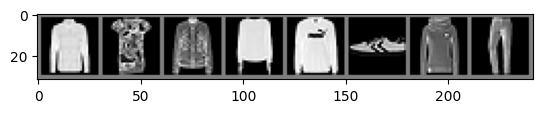

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display the images
def imshow(img):
  img = img*0.5 + 0.5
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img, (1, 2, 0)))
  plt.show()

for i, (images, labels) in enumerate(trainloader, 0):
  # Plot some images
  imshow(torchvision.utils.make_grid(images[:8])) # Display 8 images from the batch
  break

### Model

In [4]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

# Initialize the weights using Xavier Glorot initialization
for layer in model:
  if isinstance(layer, nn.Linear):
    init.kaiming_uniform_(layer.weight, nonlinearity='relu')
    if layer.bias is not None:
      layer.bias.data.fill_(0)

model = model.to(device)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)


### Loss, Optimizer, and Evaluation Function

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [6]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
  model.eval()
  test_loss = 0.0
  running_correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in testloader:
      # Move inputs and labels to the device
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)
      test_loss += loss.item()

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      running_correct += (predicted == labels).sum().item()

  accuracy = 100 * running_correct / total
  test_loss = test_loss / len(testloader)
  return test_loss, accuracy

### Train

In [7]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 100

In [8]:
# train
for epoch in range(max_epoch):
  model.train()
  running_loss = 0.0
  running_correct = 0 # to track number of correct predictions
  total = 0           # to track number of samples

  for i, (inputs, labels) in enumerate(trainloader, 0):
    # Move inputs and labels to the device
    inputs, labels = inputs.to(device), labels.to(device)

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    running_loss += loss.item()

    # Determine class predictions and track accuracy
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    running_correct += (predicted == labels).sum().item()

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

  epoch_accuracy = 100 * running_correct / total
  epoch_loss = running_loss / (i + 1)

  test_loss, test_accuracy = evaluate(model, testloader, criterion)
  print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

  # save for plot
  train_losses.append(epoch_loss)
  train_accuracies.append(epoch_accuracy)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

Epoch [1/100], Loss: 1.2926, Accuracy: 57.37%, Test Loss: 0.8001, Test Accuracy: 72.91%
Epoch [2/100], Loss: 0.6898, Accuracy: 76.26%, Test Loss: 0.6350, Test Accuracy: 77.84%
Epoch [3/100], Loss: 0.5812, Accuracy: 79.98%, Test Loss: 0.5668, Test Accuracy: 79.73%
Epoch [4/100], Loss: 0.5258, Accuracy: 81.91%, Test Loss: 0.5278, Test Accuracy: 81.14%
Epoch [5/100], Loss: 0.4935, Accuracy: 82.95%, Test Loss: 0.5025, Test Accuracy: 82.40%
Epoch [6/100], Loss: 0.4701, Accuracy: 83.72%, Test Loss: 0.4850, Test Accuracy: 82.89%
Epoch [7/100], Loss: 0.4514, Accuracy: 84.34%, Test Loss: 0.4719, Test Accuracy: 83.24%
Epoch [8/100], Loss: 0.4374, Accuracy: 84.74%, Test Loss: 0.4640, Test Accuracy: 83.60%
Epoch [9/100], Loss: 0.4263, Accuracy: 85.09%, Test Loss: 0.4507, Test Accuracy: 83.94%
Epoch [10/100], Loss: 0.4159, Accuracy: 85.54%, Test Loss: 0.4432, Test Accuracy: 84.08%
Epoch [11/100], Loss: 0.4072, Accuracy: 85.84%, Test Loss: 0.4364, Test Accuracy: 84.44%
Epoch [12/100], Loss: 0.3992, 

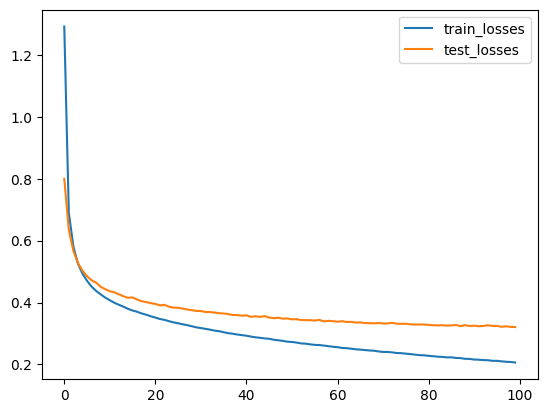

In [9]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

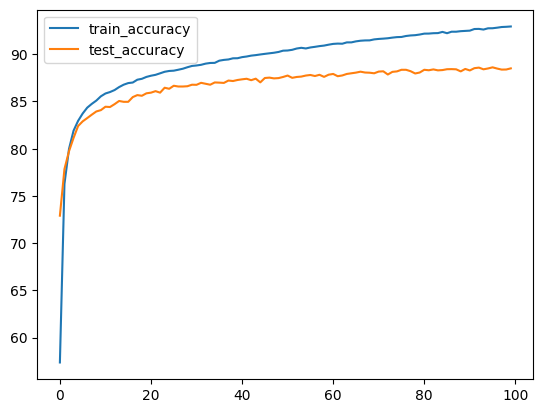

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()